In [2]:
import xarray as xr
from dask.diagnostics.progress import ProgressBar

Mask by latitude

In [ ]:
da = xr.open_zarr('../data/intermediate/evp_1200itr_long.zarr')

def lat_filter(x: xr.DataArray, threshold):
    mask = x.lat.values >= threshold if threshold > 0 else x.lat.values <= threshold
    return x.isel(z=mask)

with ProgressBar():
    print("masking arctic")
    da = lat_filter(da, 80)
    print("saving to zarr")
    da = da.drop_encoding()
    da.to_zarr('../data/processed/arctic/80deg.zarr', mode='w', align_chunks=True, zarr_format=2)

    #print("antarctic mask")
    #antarctic = lat_filter(da, -50)
    #print(" saving to zarr")
    #antarctic.to_zarr('../data/processed/full_antarctic.zarr', mode='w', zarr_format=2, align_chunks=True)


masking arctic
[########################################] | 100% Completed | 610.63 ms
saving to zarr
[########################################] | 100% Completed | 2.96 sms
[########################################] | 100% Completed | 170.08 s
[########################################] | 100% Completed | 3.36 ss
[########################################] | 100% Completed | 175.79 s
[########################################] | 100% Completed | 481.50 s


Mask by date

In [ ]:
month_subsets = [1]
da = xr.open_zarr('../data/processed/arctic/80deg.zarr')

with ProgressBar():
    for month_subset in month_subsets:
        print(f"subsetting to max month {month_subset}")
        mask = (da.time_features.dt.month.values <= month_subset)
        arctic_subset = da.isel(z=mask)
        arctic_subset.to_zarr(f'../data/processed/arctic/{month_subset}.zarr', mode='w', align_chunks=True, zarr_format=2)

subsetting to max month 1
[########################################] | 100% Completed | 102.75 ms
[########################################] | 100% Completed | 19.37 s
[########################################] | 100% Completed | 385.92 ms
[########################################] | 100% Completed | 396.34 ms
[########################################] | 100% Completed | 14.42 s


Precompute velocity difference

In [ ]:
da = xr.open_zarr('../data/processed/arctic/80deg.zarr')

print('calculating d(sivelu)')
d_sivelu = da.labels.loc["sivelu"] - da.features.loc["sivelu"]
print('calculating d(sivelv)')
d_sivelv = da.labels.loc["sivelv"] - da.features.loc["sivelv"]

da = da.assign({
    'd_labels': xr.concat([d_sivelu, d_sivelv], dim='d_label')
})
da = da.assign_coords({
    'd_label': ['d_sivelu', 'd_sivelv']
})

print('saving to zarr')
da.to_zarr('../data/processed/arctic/80deg_diff.zarr', mode='w', zarr_format=2)

calculating d(sivelu)
calculating d(sivelv)
saving to zarr


Display SIV plot

13 1002821


C:\Users\charl\AppData\Local\Temp\ipykernel_23916\2051108756.py:126: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


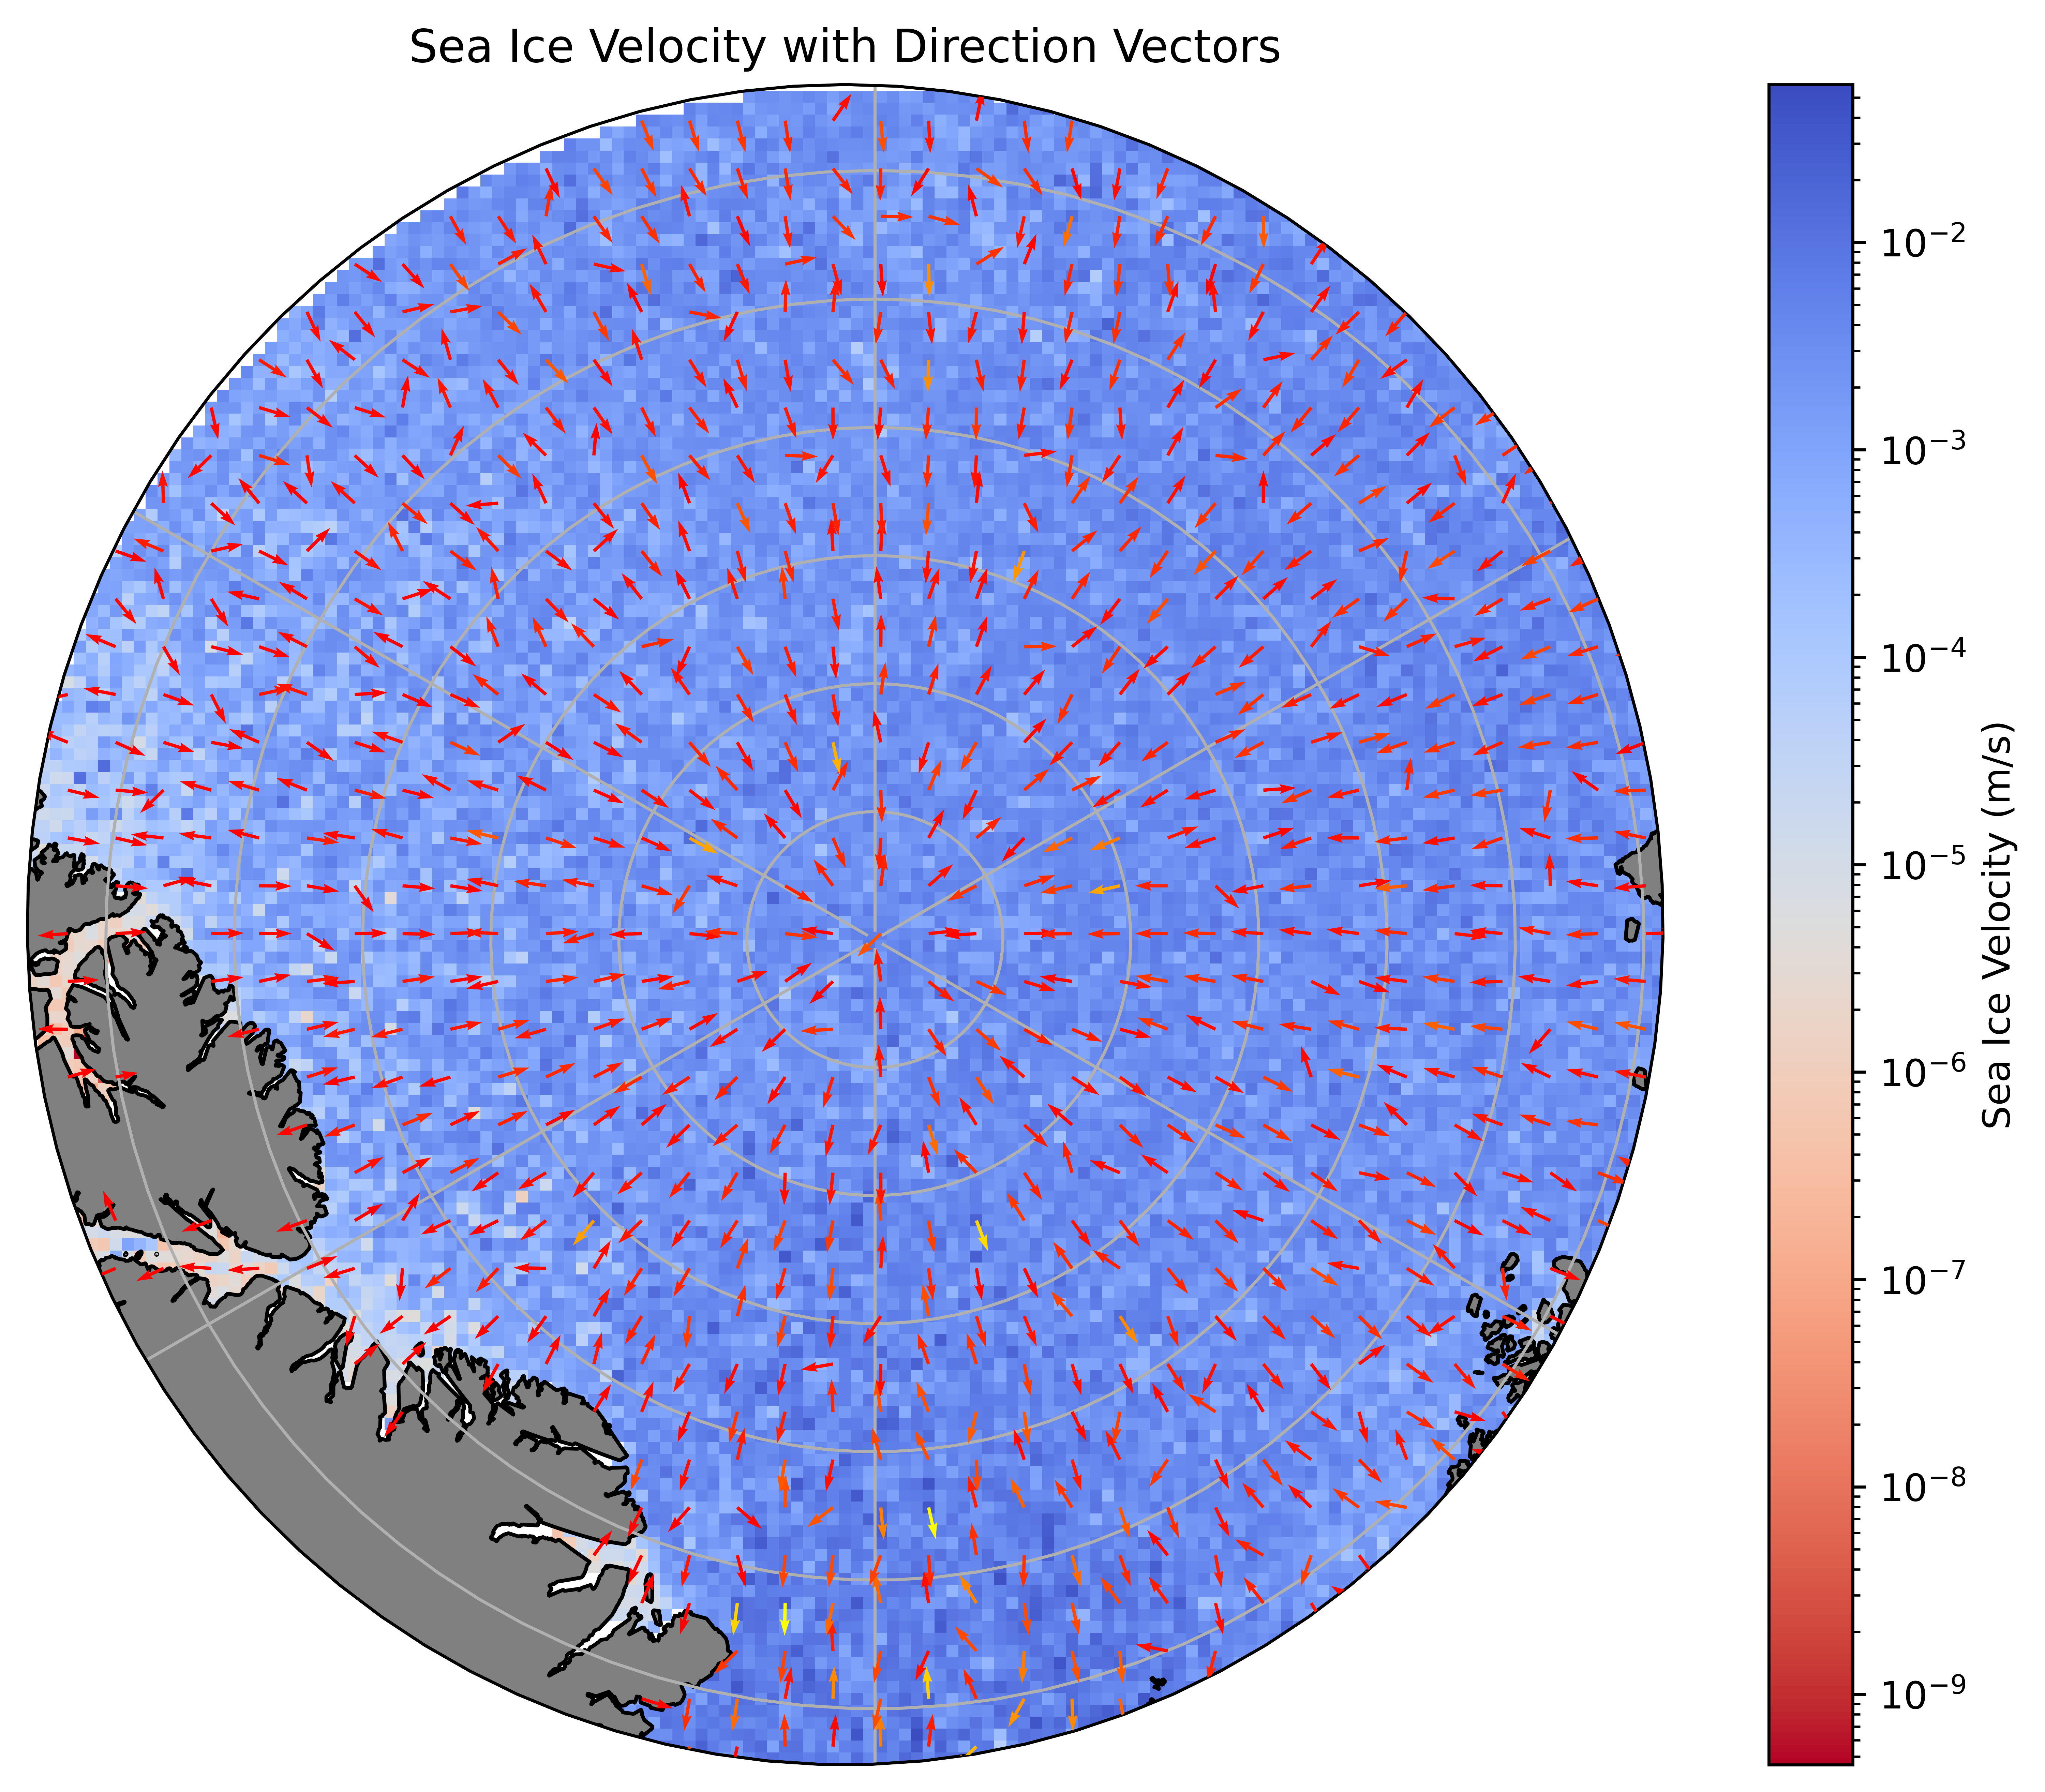

In [17]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import torch
import torch.nn.functional as F
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

ds = xr.open_zarr('../data/processed/arctic/80deg.zarr')

stride = max(1, ds.sizes['z'] // 1_000_000)
print(stride, ds.sizes['z'] // stride)

# Extract Coordinates
lat = ds.coords["lat"].values[::stride]
lon = ds.coords["lon"].values[::stride]

# Extract Vector Components (and subset them)
u_true = ds.labels.loc['sivelu'] .values[::stride]
v_true = ds.labels.loc['sivelv'].values[::stride]
u_pred = ds.features.loc['sivelu'].values[::stride]
v_pred = ds.features.loc['sivelv'].values[::stride]

# Calculate scalars
y_true_mag = torch.hypot(torch.tensor(u_true), torch.tensor(v_true))
y_pred_mag = torch.hypot(torch.tensor(u_pred), torch.tensor(v_pred))
scalar_field = F.l1_loss(y_pred_mag, y_true_mag, reduction="none").numpy()


projection = ccrs.NorthPolarStereo()
extent = [-180, 180, 80, 90]

src_crs = ccrs.PlateCarree()

# Project lat/lon to metres
coords_proj = projection.transform_points(src_crs, lon, lat)
x_points = coords_proj[:, 0]
y_points = coords_proj[:, 1]

grid_x = np.linspace(-4000000, 4000000, 512)
grid_y = np.linspace(-4000000, 4000000, 512)
grid_x_2d, grid_y_2d = np.meshgrid(grid_x, grid_y)

def interpolate_and_mask(values):
    # Linear interpolation
    grid = griddata(
        (x_points, y_points), values, (grid_x_2d, grid_y_2d), method="linear"
    )
    # Distance masking
    tree = cKDTree(np.column_stack((x_points, y_points)))
    # Query tree (flatten grid for query)
    grid_pixels = np.column_stack((grid_x_2d.ravel(), grid_y_2d.ravel()))
    dist, _ = tree.query(grid_pixels)
    dist = dist.reshape(grid_x_2d.shape)

    grid[dist > 15000] = np.nan
    return grid

# Interpolate values
grid_u = interpolate_and_mask(u_true - u_pred)
grid_v = interpolate_and_mask(v_true - v_pred)
grid_scalar = interpolate_and_mask(scalar_field)

# Subsample grid for quiver plot
q_str = 4
quiver_x = grid_x_2d[::q_str, ::q_str]
quiver_y = grid_y_2d[::q_str, ::q_str]
quiver_u = grid_u[::q_str, ::q_str]
quiver_v = grid_v[::q_str, ::q_str]
quiver_speed = np.hypot(quiver_u, quiver_v)

quiver_u_norm = quiver_u / (quiver_speed + 1e-7)
quiver_v_norm = quiver_v / (quiver_speed + 1e-7)

# Unproject x/y coords back to lat/lon for accurate directions
quiver_geo = src_crs.transform_points(projection, quiver_x, quiver_y)
quiver_lon = quiver_geo[:, :, 0]
quiver_lat = quiver_geo[:, :, 1]


fig = plt.figure(figsize=(10, 8), dpi=800)
ax = plt.axes(projection=projection)
ax.set_extent(extent, src_crs)
ax.add_feature(cfeature.LAND, zorder=2, facecolor="gray", edgecolor="black")
ax.gridlines()

# Circular Boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Plot scalars
mesh = ax.pcolormesh(
    grid_x_2d,
    grid_y_2d,
    grid_scalar,
    transform=projection,
    norm=colors.LogNorm(),
    cmap="coolwarm_r",
    shading="auto",
    zorder=1,
)
plt.colorbar(mesh, ax=ax, label="Sea Ice Velocity (m/s)")

# Plot vectors
q = ax.quiver(
    quiver_lon,
    quiver_lat,
    quiver_u_norm,
    quiver_v_norm,
    quiver_speed,
    transform=ccrs.PlateCarree(),
    cmap="autumn",
    scale=50,
    width=0.002,
    headwidth=3,
    zorder=3,
)

ax.set_title("Sea Ice Velocity with Direction Vectors")
fig.show()